##Telco Customer Churn Prediction



In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time
import warnings
warnings.simplefilter(action="ignore")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import (classification_report, accuracy_score, recall_score,
                             precision_score, f1_score, roc_auc_score, precision_recall_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/arabelazulfa/Telco-Customer-Churn-Prediction/refs/heads/main/Telco_Customer_Churn.csv')

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_df = df.select_dtypes(include='number')
    # quantile() işlemi
    quantiles = numeric_df.describe([0, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T
    print(quantiles)

In [ ]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

In [ ]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400,306.6,Yes


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables include those with numeric appearance.

    Parameters
    ----------
    dataframe: pandas.DataFrame
        The dataframe to analyze.
    cat_th: int
        Threshold for numerical but categorical variables.
    car_th: int
        Threshold for categorical but cardinal variables.

    Returns
    -------
    cat_cols : list
        Categorical columns
    num_cols : list
        Numerical columns
    cat_but_car : list
        Categorical but cardinal columns
    num_but_cat : list
        Numerical but categorical columns
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat


In [ ]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [ ]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

In [ ]:
num_cols

['tenure', 'MonthlyCharges']

In [ ]:
cat_but_car

['customerID', 'TotalCharges']

In [ ]:
num_but_cat

['SeniorCitizen']

In [ ]:
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette="Set2")
        plt.show(block=True)

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


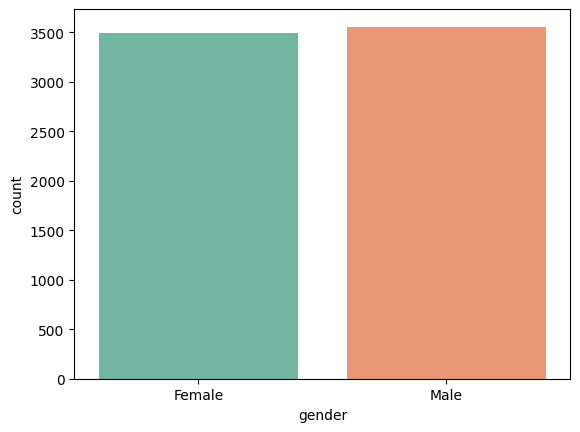

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


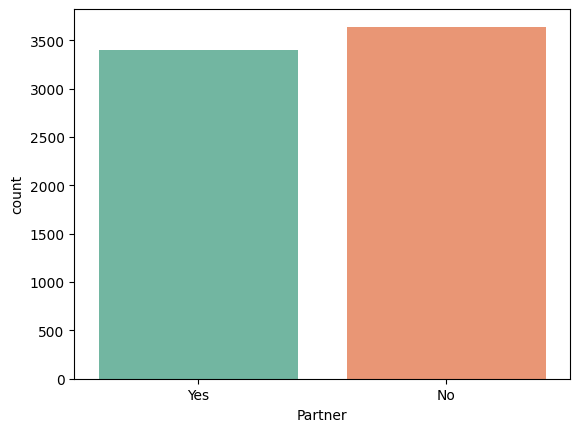

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


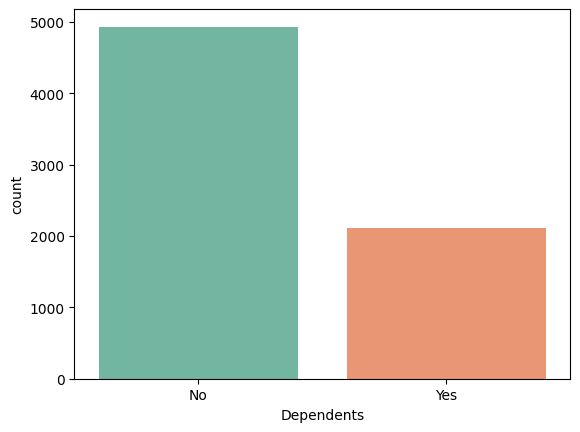

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


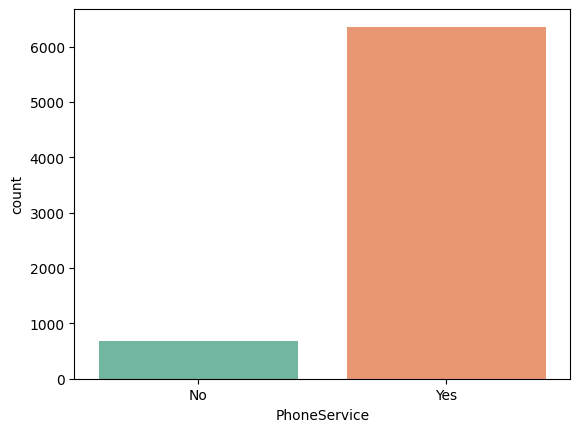

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


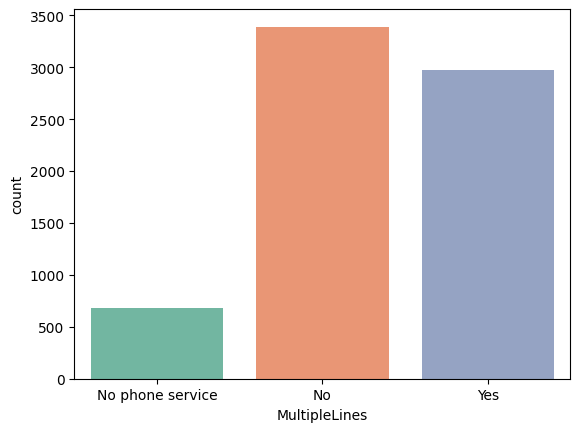

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


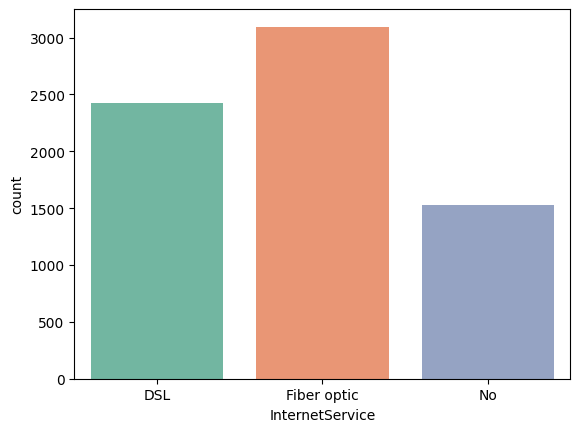

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


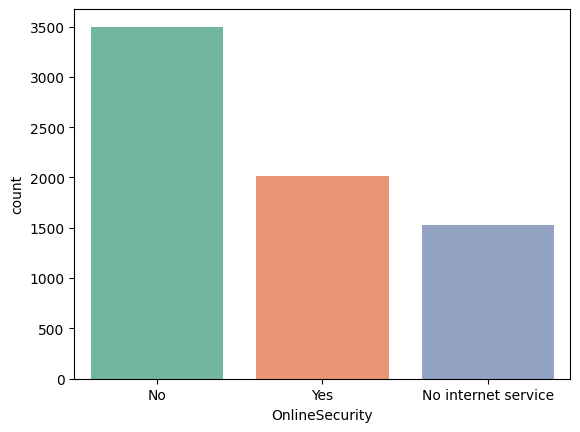

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


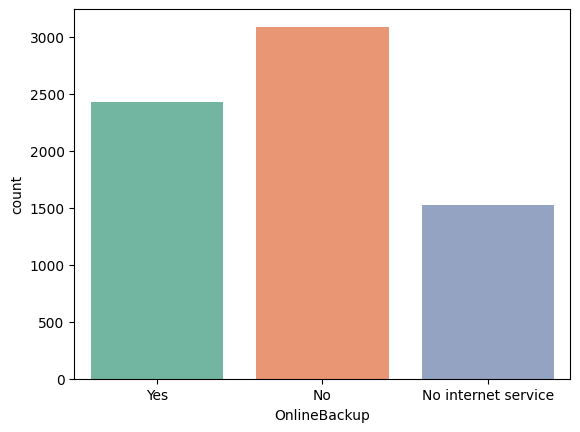

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


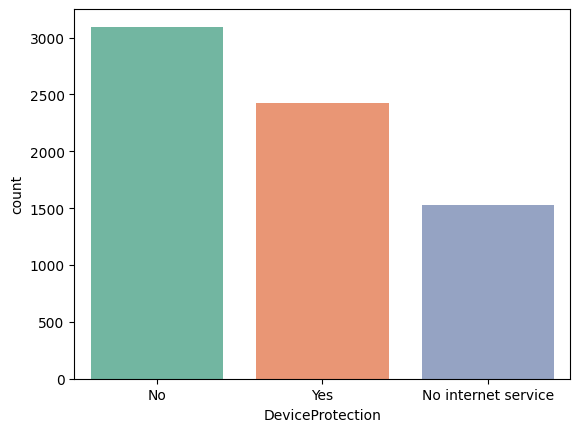

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


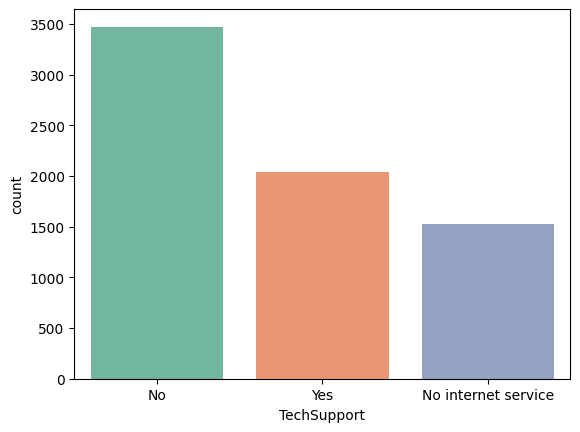

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


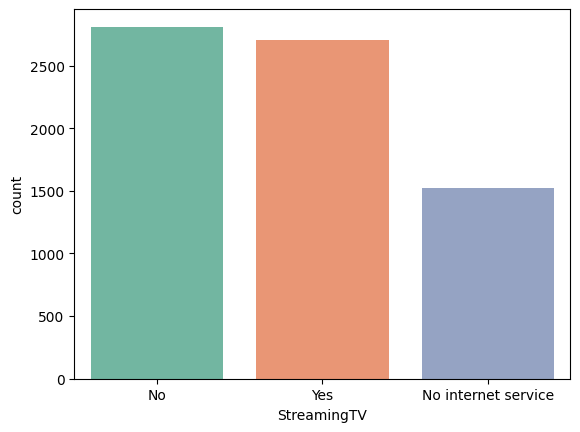

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


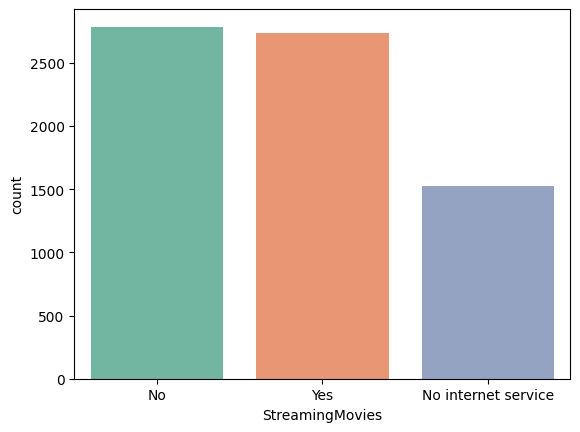

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


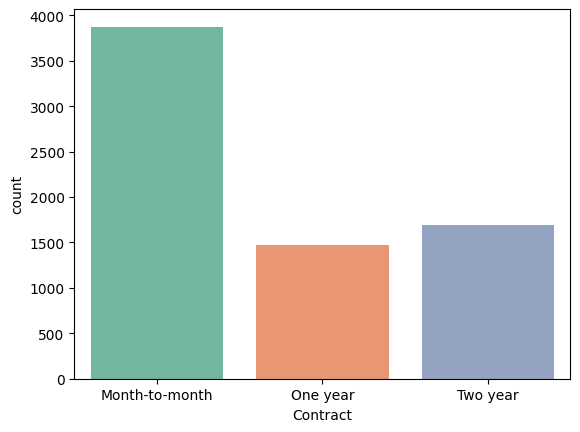

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


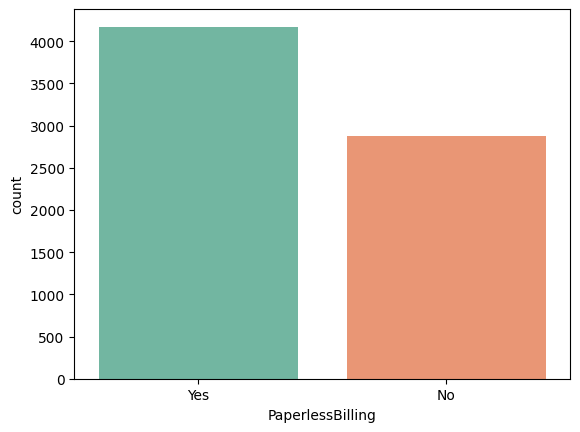

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


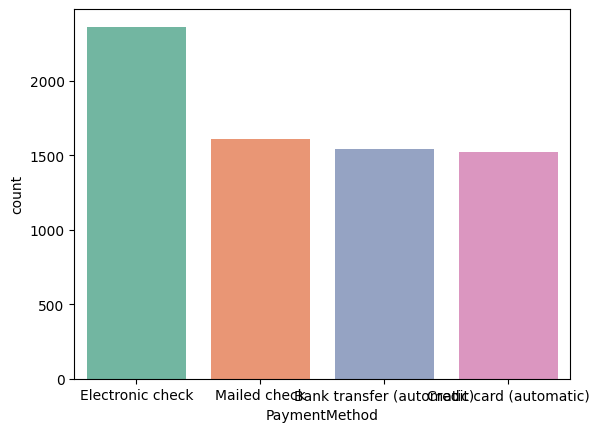

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


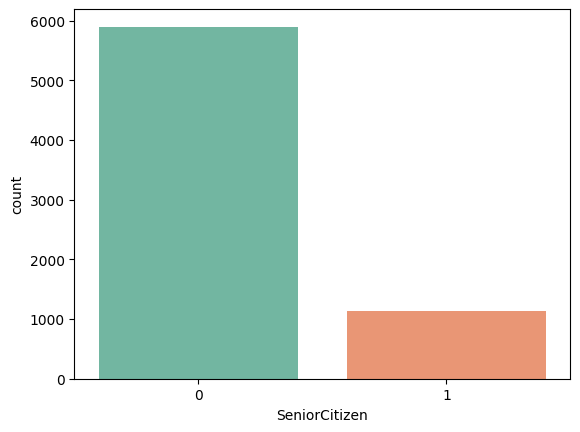

In [ ]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [ ]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        sns.histplot(data=dataframe, x=col_name, bins=20, kde=True, color="blue")
        plt.show(block=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


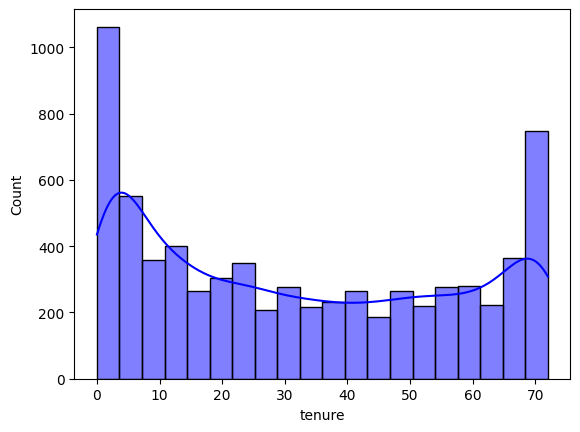

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


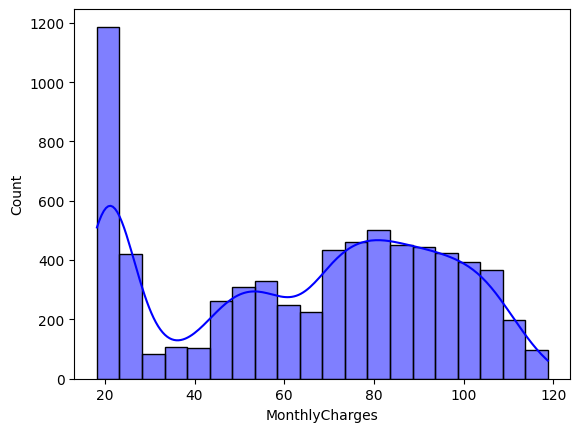

In [ ]:
for col in num_cols:
    num_summary(df, col, plot=True)

Analisis variabel kategori berdasarkan target

In [ ]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe, palette="Set2")
        plt.show(block=True)

In [ ]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [ ]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col, plot=False)

        TARGET_MEAN
gender             
Female        0.269
Male          0.262


         TARGET_MEAN
Partner             
No             0.330
Yes            0.197


            TARGET_MEAN
Dependents             
No                0.313
Yes               0.155


              TARGET_MEAN
PhoneService             
No                  0.249
Yes                 0.267


                  TARGET_MEAN
MultipleLines                
No                      0.250
No phone service        0.249
Yes                     0.286


                 TARGET_MEAN
InternetService             
DSL                    0.190
Fiber optic            0.419
No                     0.074


                     TARGET_MEAN
OnlineSecurity                  
No                         0.418
No internet service        0.074
Yes                        0.146


                     TARGET_MEAN
OnlineBackup                    
No                         0.399
No internet service        0.074
Yes                        0.2

Analisis variabel numerik berdasarkan target

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

In [ ]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col, plot=False)

       tenure_mean
Churn             
0           37.570
1           17.979


       MonthlyCharges_mean
Churn                     
0                   61.265
1                   74.441




Analisis Korelasi

In [ ]:
corr = df[num_cols].corr()

In [ ]:
corr

,tenure,MonthlyCharges
tenure,1.000,0.248
MonthlyCharges,0.248,1.000


In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Only numerical columns
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Correlation matrix
    corr = numeric_df.corr()
    cor_matrix = corr.abs()

    # Select upper triangular matrix (to remove unnecessary repetitions)
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Let's select the column pairs whose correlation is higher than the threshold
    high_corrs = [(col, row)
                  for col in cor_matrix.columns
                  for row in cor_matrix.index
                  if not pd.isna(upper_triangle_matrix.loc[row, col]) and abs(
            upper_triangle_matrix.loc[row, col]) > corr_th]

    if plot:
        # Heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu")
        plt.title("Correlation Heat Map")
        plt.show()

    return high_corrs


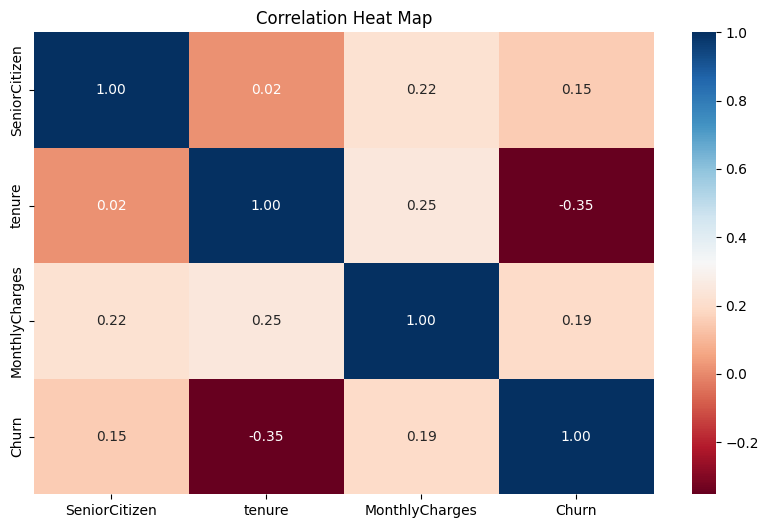

[]

In [ ]:
high_correlated_cols(df, plot=True)

Distribusi variabel tertentu

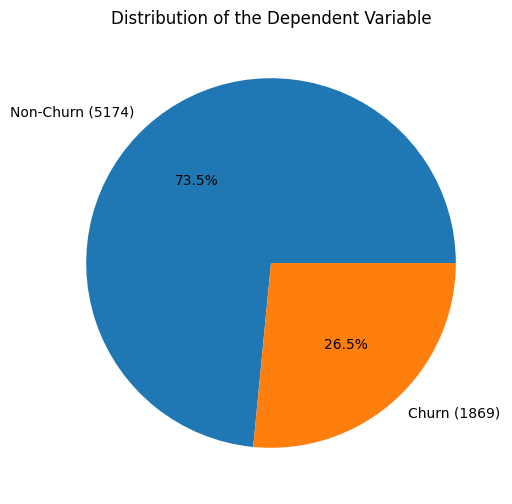

In [ ]:
# Calculate the counts of each outcome
outcome_counts = df['Churn'].value_counts()

# Calculate the total number of patients
total_patients = outcome_counts.sum()

# Calculate the percentages
percentages = outcome_counts / total_patients * 100

# Create labels with both quantity and percentage
labels = [f'Non-Churn ({outcome_counts[0]})',
          f'Churn ({outcome_counts[1]})']

# Plot the pie chart with labels and percentages
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of the Dependent Variable')
plt.show()

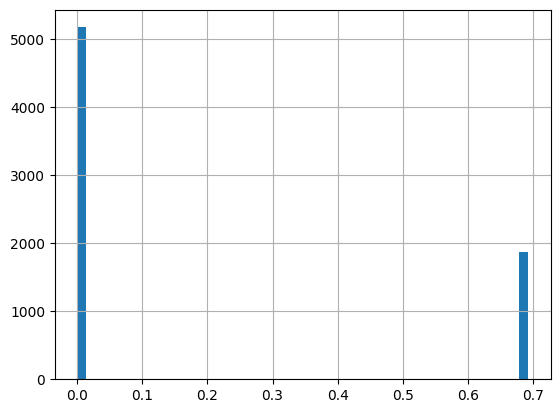

In [ ]:
np.log1p(df['Churn']).hist(bins=50)
plt.show(block=True)

Rekayasa Fitur

In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
na_columns = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [ ]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [ ]:
missing_vs_target(df, "Churn", na_columns)

In [ ]:
# Konversi string jadi float, kalau gagal jadi NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Isi NaN dengan rata-rata
df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)


In [ ]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False


Model

In [ ]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
dff = one_hot_encoder(dff, cat_cols)

In [ ]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_0,SeniorCitizen_1
0,7590-VHVEG,1,29.850,29.850,0,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False
1,5575-GNVDE,34,56.950,1889.500,0,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False
2,3668-QPYBK,2,53.850,108.150,1,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False
3,7795-CFOCW,45,42.300,1840.750,0,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
4,9237-HQITU,2,70.700,151.650,1,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False


In [ ]:
scaler = RobustScaler()

In [ ]:
dff[num_cols] = scaler.fit_transform(dff[num_cols])

In [ ]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_0,SeniorCitizen_1
0,7590-VHVEG,-0.609,-0.745,29.850,0,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False
1,5575-GNVDE,0.109,-0.247,1889.500,0,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False
2,3668-QPYBK,-0.587,-0.304,108.150,1,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False
3,7795-CFOCW,0.348,-0.516,1840.750,0,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
4,9237-HQITU,-0.587,0.006,151.650,1,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False


In [ ]:
y = dff["Churn"]
X = dff.drop(["Churn", "customerID"], axis=1)

In [ ]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(verbose=-1, random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

base_models_metrics = []

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    base_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


########## LR ##########
Accuracy: 0.7978
AUC: 0.8388
Recall: 0.5399
Precision: 0.6421
F1: 0.5862
########## KNN ##########
Accuracy: 0.7493
AUC: 0.7009
Recall: 0.382
Precision: 0.5387
F1: 0.4468
########## CART ##########
Accuracy: 0.7271
AUC: 0.6534
Recall: 0.4922
Precision: 0.4859
F1: 0.4889
########## RF ##########
Accuracy: 0.7886
AUC: 0.8209
Recall: 0.4831
Precision: 0.6342
F1: 0.5483
########## XGB ##########
Accuracy: 0.7815
AUC: 0.8211
Recall: 0.5083
Precision: 0.6062
F1: 0.5527
########## LightGBM ##########
Accuracy: 0.7948
AUC: 0.8346
Recall: 0.5185
Precision: 0.6409
F1: 0.5731
########## CatBoost ##########
Accuracy: 0.7951
AUC: 0.8386
Recall: 0.5029
Precision: 0.6475
F1: 0.5659


In [ ]:
# Dictionary containing the updated metric results
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}

# Creating a DataFrame from the updated metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Model Performance Comparison After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)

Fitur penting untuk model

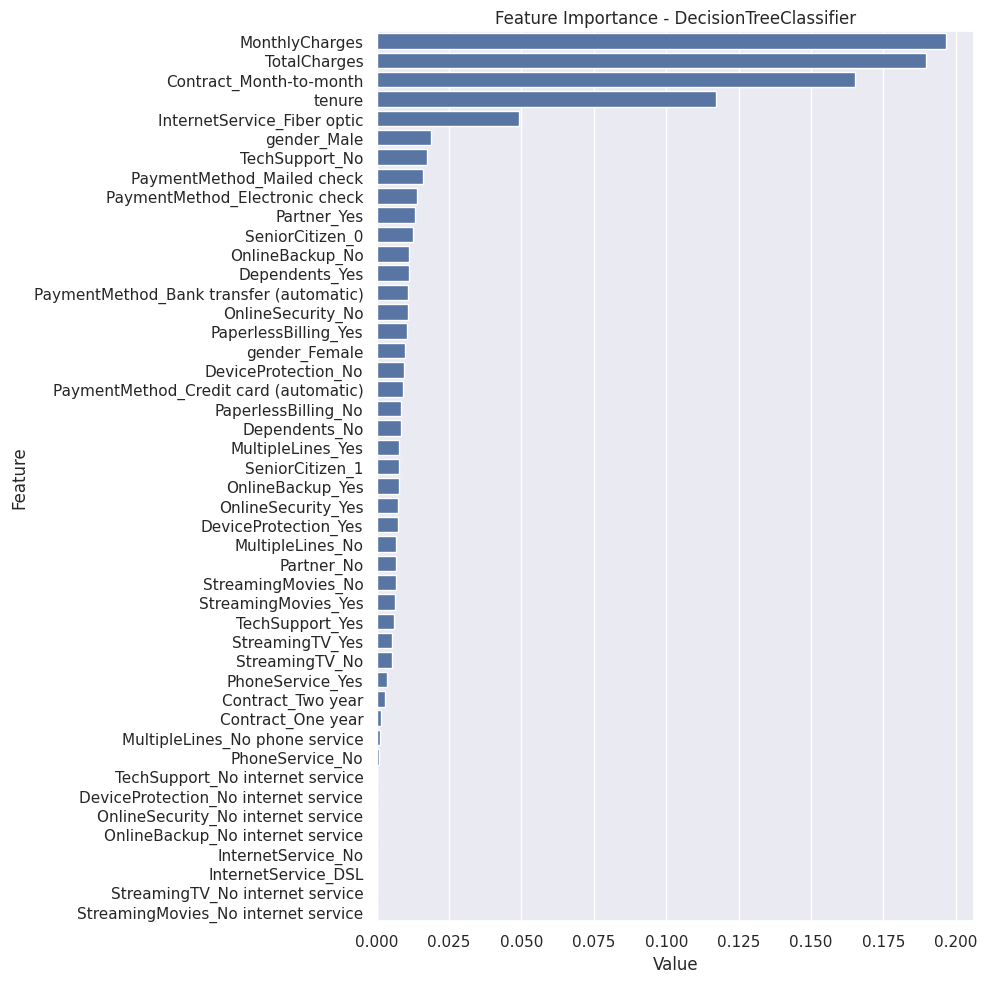

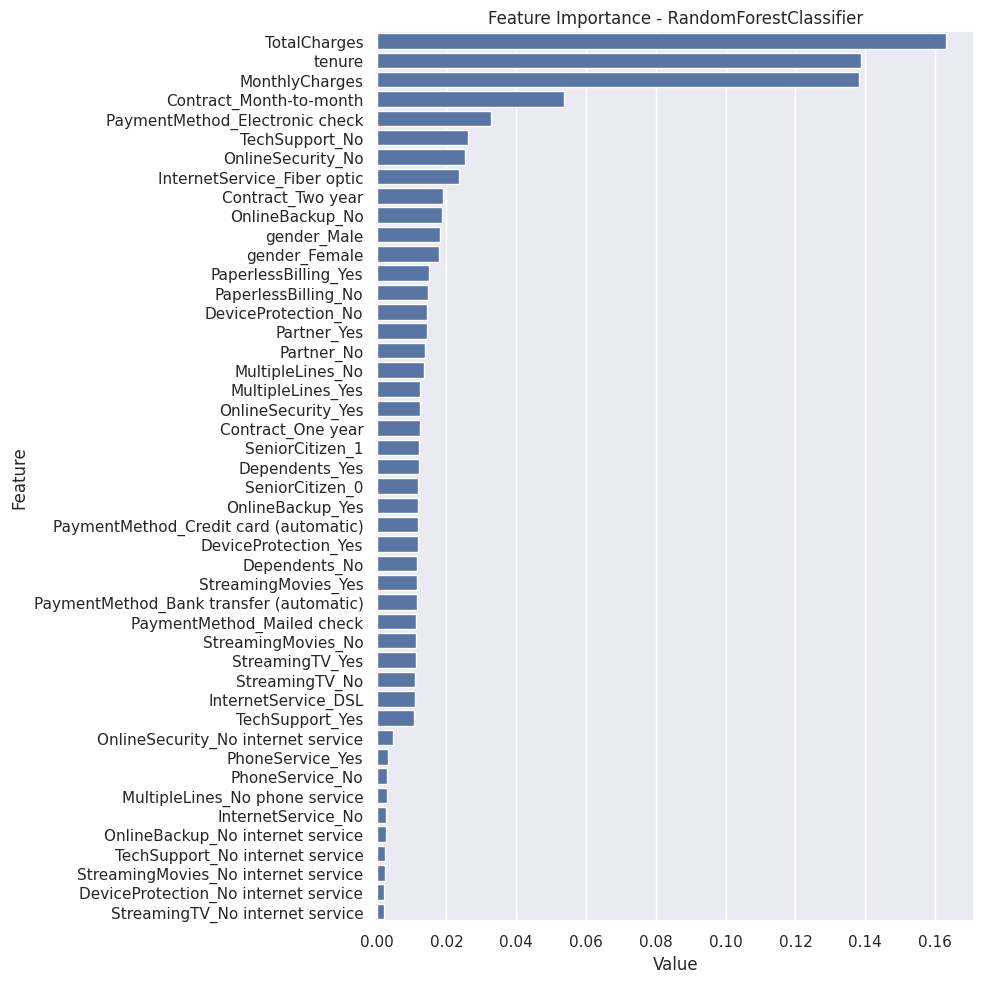

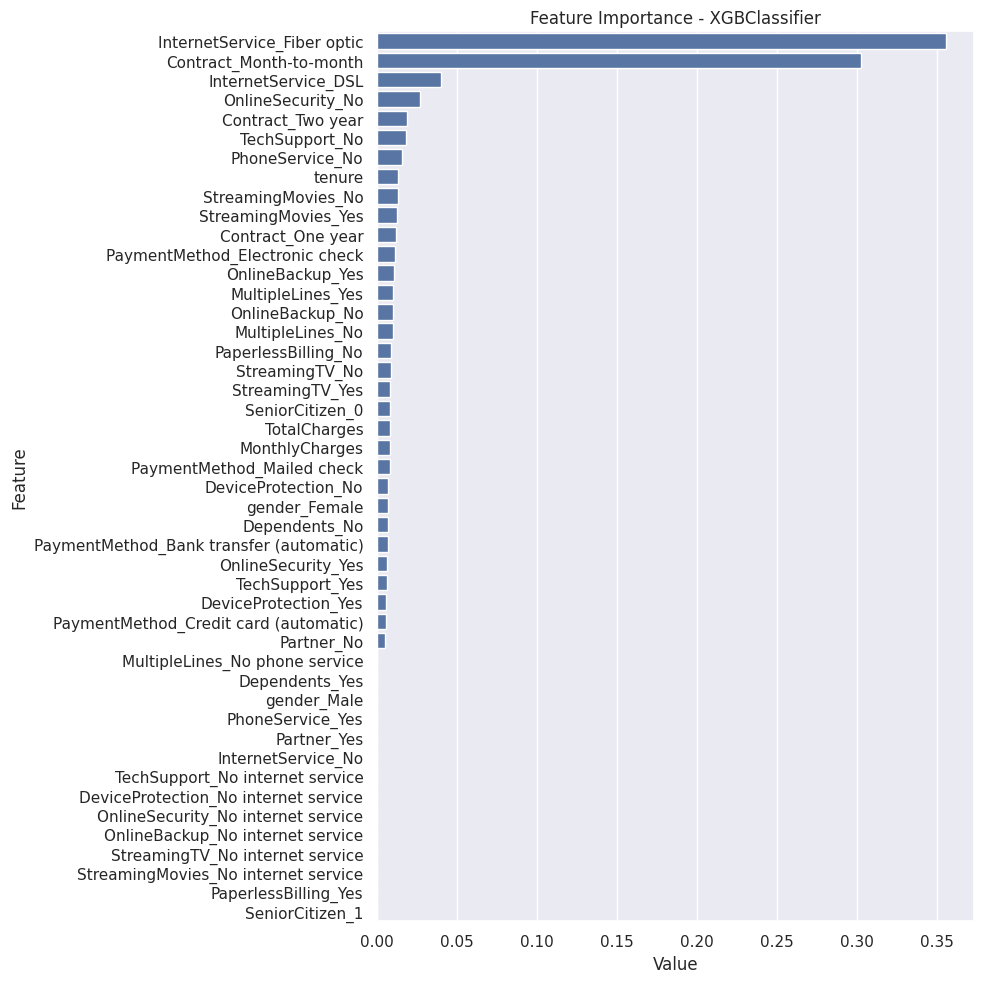

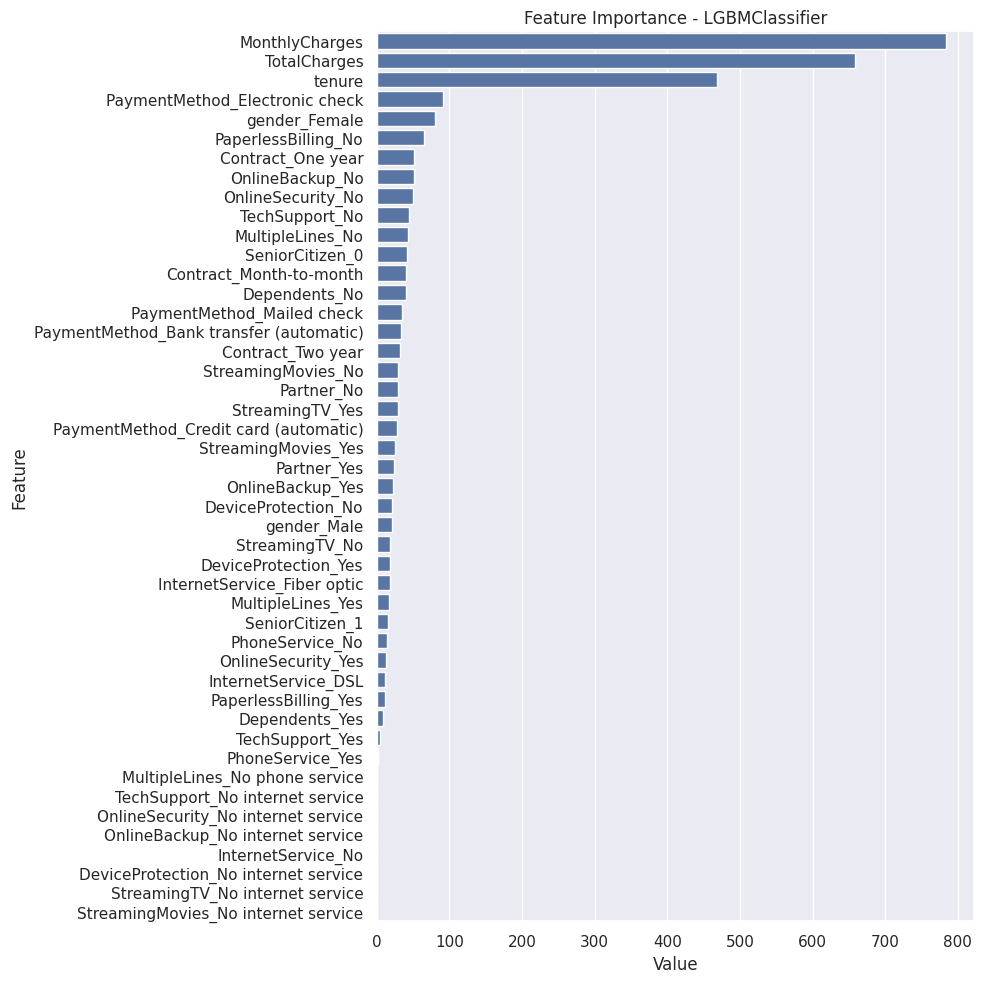

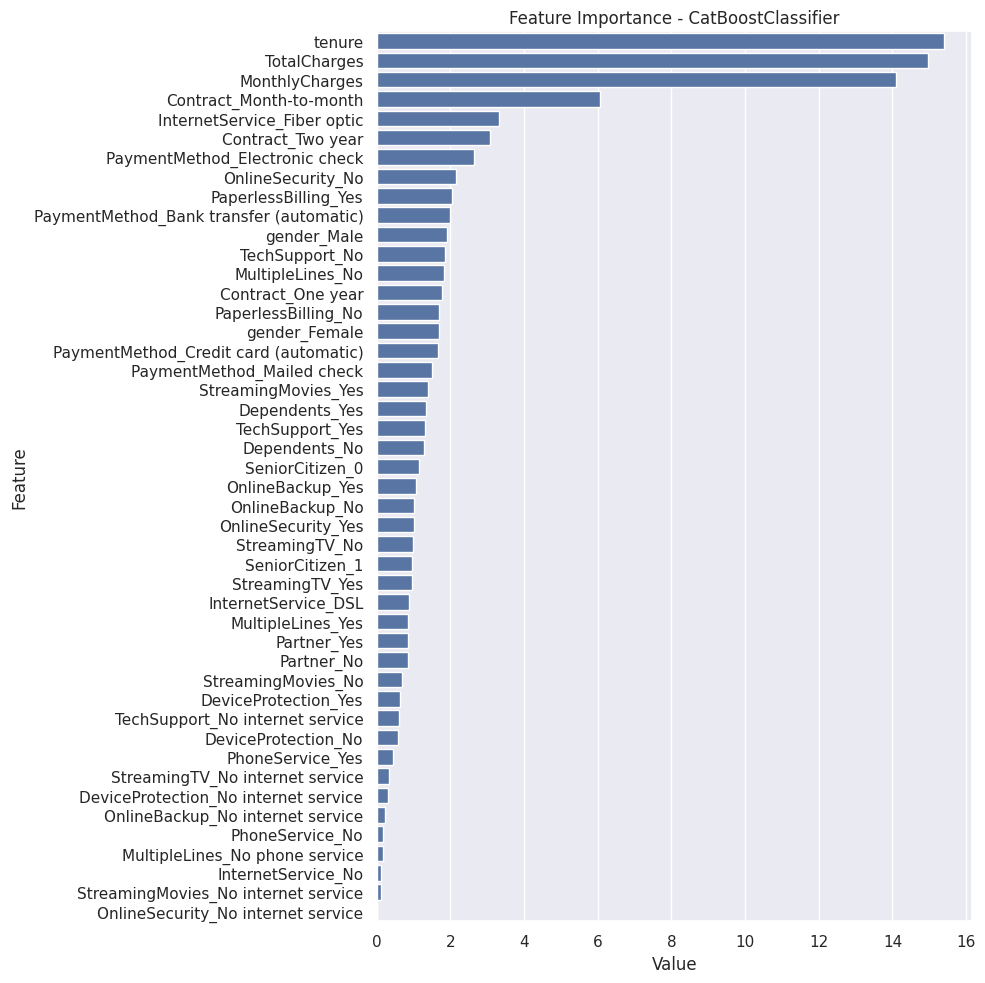

In [ ]:
models = [DecisionTreeClassifier(random_state=12345),
         RandomForestClassifier(random_state=12345),
         XGBClassifier(random_state=12345),
         LGBMClassifier(verbose=-1, random_state=12345),
         CatBoostClassifier(verbose=False, random_state=12345)]

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

for model in models:
    model.fit(X, y)
    plot_importance(model, X)

Ekstraksi Fitur

In [ ]:
bins = [0, 12, 24, 36, 48, 60, 72]
labels = [1, 2, 3, 4, 5, 6]
df["NEW_TENURE_YEAR"] = pd.cut(df["tenure"], bins=bins, labels=labels, right=True)

In [ ]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)


In [ ]:
df["NEW_Contract_Type"] = df["Contract"].apply(
    lambda x: 2 if x == "Two year" else (1 if x == "One year" else 0))

In [ ]:
df["NEW_Young_Not_Contract"] = df.apply(lambda x: 1 if (x["NEW_Contract_Type"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [ ]:
df["Partner"] = df["Partner"].map({"Yes": 1, "No": 0})
df["Dependents"] = df["Dependents"].map({"Yes": 1, "No": 0})


In [ ]:
df["NEW_Family_Size"] = df["Partner"] + df["Dependents"] + 1

In [ ]:
df["PhoneService"] = df["PhoneService"].map({"Yes": 1, "No": 0})


In [ ]:
df["InternetService"] = df["InternetService"].apply(lambda x: 0 if x == "No" else 1)


In [ ]:
# Total number of services received by the person

df['NEW_TotalServices'] = (df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1) \
                                        + df["InternetService"] + df["PhoneService"]

In [ ]:
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if
                                                       x in ["Bank transfer (automatic)","Credit card (automatic)"]
                                                       else 0)

In [ ]:
# average monthly payment

df["NEW_AVG_Charges"] = df["TotalCharges"] / df["tenure"]

In [ ]:
df["NEW_AVG_Monthly_Charges"] = df["tenure"] / df["MonthlyCharges"]

In [ ]:
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [ ]:
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [ ]:
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [ ]:
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [ ]:
df.columns = [col.upper() for col in df.columns]

In [ ]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_TENURE_YEAR,NEW_CONTRACT_TYPE,NEW_YOUNG_NOT_CONTRACT,NEW_FAMILY_SIZE,NEW_TOTALSERVICES,NEW_FLAG_AUTOPAYMENT,NEW_AVG_CHARGES,NEW_AVG_MONTHLY_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,NEW_NOPROT,NEW_FLAG_ANY_STREAMING
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,1,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,1,0,1,2,2,0,29.850,0.034,1.000,9.950,1,0
1,5575-GNVDE,Male,0,0,0,34,1,No,1,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,3,1,0,1,4,0,55.574,0.597,0.976,11.390,1,0
2,3668-QPYBK,Male,0,0,0,2,1,No,1,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,1,0,1,1,4,0,54.075,0.037,1.004,10.770,1,0
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,1,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,4,1,0,1,4,1,40.906,1.064,0.967,8.460,1,0
4,9237-HQITU,Female,0,0,0,2,1,No,1,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,1,0,1,1,2,0,75.825,0.028,1.072,23.567,1,0


Encoding

In [ ]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 33
cat_cols: 25
num_cols: 7
cat_but_car: 1
num_but_cat: 14


In [ ]:
cat_cols

['GENDER',
 'MULTIPLELINES',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'INTERNETSERVICE',
 'CHURN',
 'NEW_TENURE_YEAR',
 'NEW_CONTRACT_TYPE',
 'NEW_YOUNG_NOT_CONTRACT',
 'NEW_FAMILY_SIZE',
 'NEW_TOTALSERVICES',
 'NEW_FLAG_AUTOPAYMENT',
 'NEW_NOPROT',
 'NEW_FLAG_ANY_STREAMING']

In [ ]:
num_cols

['TENURE',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'NEW_AVG_CHARGES',
 'NEW_AVG_MONTHLY_CHARGES',
 'NEW_INCREASE',
 'NEW_AVG_SERVICE_FEE']

In [ ]:
cat_but_car

['CUSTOMERID']

In [ ]:
num_but_cat

['SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'INTERNETSERVICE',
 'CHURN',
 'NEW_TENURE_YEAR',
 'NEW_CONTRACT_TYPE',
 'NEW_YOUNG_NOT_CONTRACT',
 'NEW_FAMILY_SIZE',
 'NEW_TOTALSERVICES',
 'NEW_FLAG_AUTOPAYMENT',
 'NEW_NOPROT',
 'NEW_FLAG_ANY_STREAMING']

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [ ]:
binary_cols2 = [col for col in df.columns if df[col].dtypes == "O" or df[col].dtypes == "int" and df[col].nunique() == 2]

In [ ]:
binary_cols2

['CUSTOMERID',
 'GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'CHURN',
 'NEW_YOUNG_NOT_CONTRACT',
 'NEW_FLAG_AUTOPAYMENT',
 'NEW_NOPROT',
 'NEW_FLAG_ANY_STREAMING']

In [ ]:
for col in binary_cols2:
    df = label_encoder(df, col)

In [ ]:
cat_cols = [col for col in cat_cols if col not in binary_cols2 and col not in ["CHURN", "NEW_TOTALSERVICES"]]

In [ ]:
cat_cols

['NEW_TENURE_YEAR', 'NEW_CONTRACT_TYPE', 'NEW_FAMILY_SIZE']

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [ ]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_YOUNG_NOT_CONTRACT,NEW_TOTALSERVICES,NEW_FLAG_AUTOPAYMENT,NEW_AVG_CHARGES,NEW_AVG_MONTHLY_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,NEW_NOPROT,NEW_FLAG_ANY_STREAMING,NEW_TENURE_YEAR_2,NEW_TENURE_YEAR_3,NEW_TENURE_YEAR_4,NEW_TENURE_YEAR_5,NEW_TENURE_YEAR_6,NEW_CONTRACT_TYPE_1,NEW_CONTRACT_TYPE_2,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3
0,5375,0,0,1,0,1,0,1,1,0,2,0,0,0,0,0,1,2,29.850,29.850,0,1,2,0,29.850,0.034,1.000,9.950,1,0,False,False,False,False,False,False,False,True,False
1,3962,1,0,0,0,34,1,0,1,2,0,2,0,0,0,1,0,3,56.950,1889.500,0,0,4,0,55.574,0.597,0.976,11.390,1,0,False,True,False,False,False,True,False,False,False
2,2564,1,0,0,0,2,1,0,1,2,2,0,0,0,0,0,1,3,53.850,108.150,1,1,4,0,54.075,0.037,1.004,10.770,1,0,False,False,False,False,False,False,False,False,False
3,5535,1,0,0,0,45,0,1,1,2,0,2,2,0,0,1,0,0,42.300,1840.750,0,0,4,1,40.906,1.064,0.967,8.460,1,0,False,False,True,False,False,True,False,False,False
4,6511,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.700,151.650,1,1,2,0,75.825,0.028,1.072,23.567,1,0,False,False,False,False,False,False,False,False,False


Standarisasi

In [ ]:
df = df.replace([np.inf, -np.inf], 0)

In [ ]:
scaler = RobustScaler()

In [ ]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_YOUNG_NOT_CONTRACT,NEW_TOTALSERVICES,NEW_FLAG_AUTOPAYMENT,NEW_AVG_CHARGES,NEW_AVG_MONTHLY_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,NEW_NOPROT,NEW_FLAG_ANY_STREAMING,NEW_TENURE_YEAR_2,NEW_TENURE_YEAR_3,NEW_TENURE_YEAR_4,NEW_TENURE_YEAR_5,NEW_TENURE_YEAR_6,NEW_CONTRACT_TYPE_1,NEW_CONTRACT_TYPE_2,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3
0,5375,0,0,1,0,-0.609,0,1,1,0,2,0,0,0,0,0,1,2,-0.745,-0.405,0,1,2,0,-0.742,-0.683,0.000,-0.458,1,0,False,False,False,False,False,False,False,True,False
1,3962,1,0,0,0,0.109,1,0,1,2,0,2,0,0,0,1,0,3,-0.247,0.144,0,0,4,0,-0.270,0.209,-0.603,-0.221,1,0,False,True,False,False,False,True,False,False,False
2,2564,1,0,0,0,-0.587,1,0,1,2,2,0,0,0,0,0,1,3,-0.304,-0.382,1,1,4,0,-0.298,-0.677,0.104,-0.323,1,0,False,False,False,False,False,False,False,False,False
3,5535,1,0,0,0,0.348,0,1,1,2,0,2,2,0,0,1,0,0,-0.516,0.130,0,0,4,1,-0.539,0.948,-0.823,-0.703,1,0,False,False,True,False,False,True,False,False,False
4,6511,0,0,0,0,-0.587,1,0,1,0,0,0,0,0,0,0,1,2,0.006,-0.369,1,1,2,0,0.101,-0.691,1.809,1.779,1,0,False,False,False,False,False,False,False,False,False


Model Baru

In [ ]:
y = df["CHURN"]
X = df.drop(["CHURN","CUSTOMERID"], axis=1)

models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

last_models_metrics = []

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    last_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")

########## LR ##########
Accuracy: 0.8055
AUC: 0.8468
Recall: 0.5265
Precision: 0.6703
F1: 0.5896
########## KNN ##########
Accuracy: 0.7622
AUC: 0.7723
Recall: 0.5211
Precision: 0.5558
F1: 0.5378
########## CART ##########
Accuracy: 0.7274
AUC: 0.6529
Recall: 0.4922
Precision: 0.4864
F1: 0.4892
########## RF ##########
Accuracy: 0.7913
AUC: 0.8242
Recall: 0.4826
Precision: 0.6422
F1: 0.5511
########## XGB ##########
Accuracy: 0.7789
AUC: 0.8204
Recall: 0.4858
Precision: 0.6037
F1: 0.5383
########## LightGBM ##########
Accuracy: 0.7945
AUC: 0.8357
Recall: 0.5163
Precision: 0.6406
F1: 0.5717
########## CatBoost ##########
Accuracy: 0.7958
AUC: 0.8398
Recall: 0.4997
Precision: 0.6504
F1: 0.565


In [ ]:
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}
# Creating a DataFrame from the updated metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)

Fitur-Fitur penting

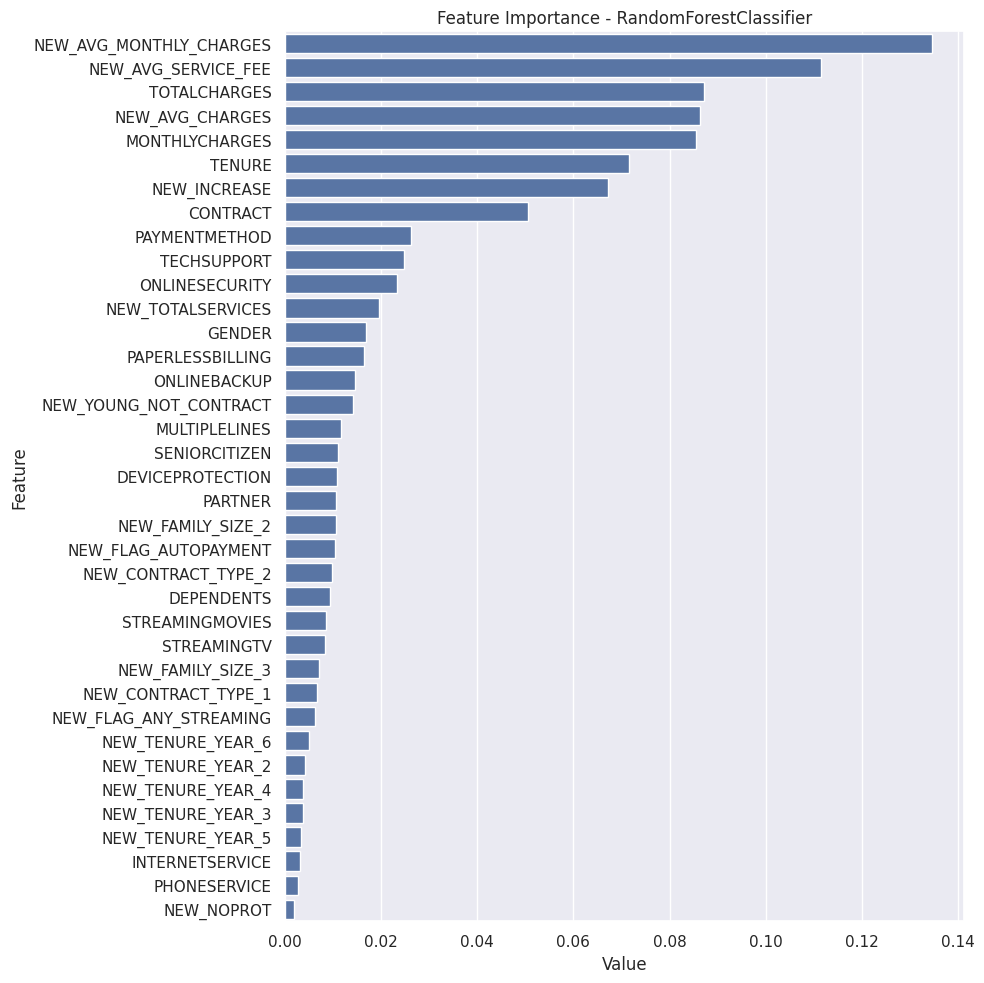

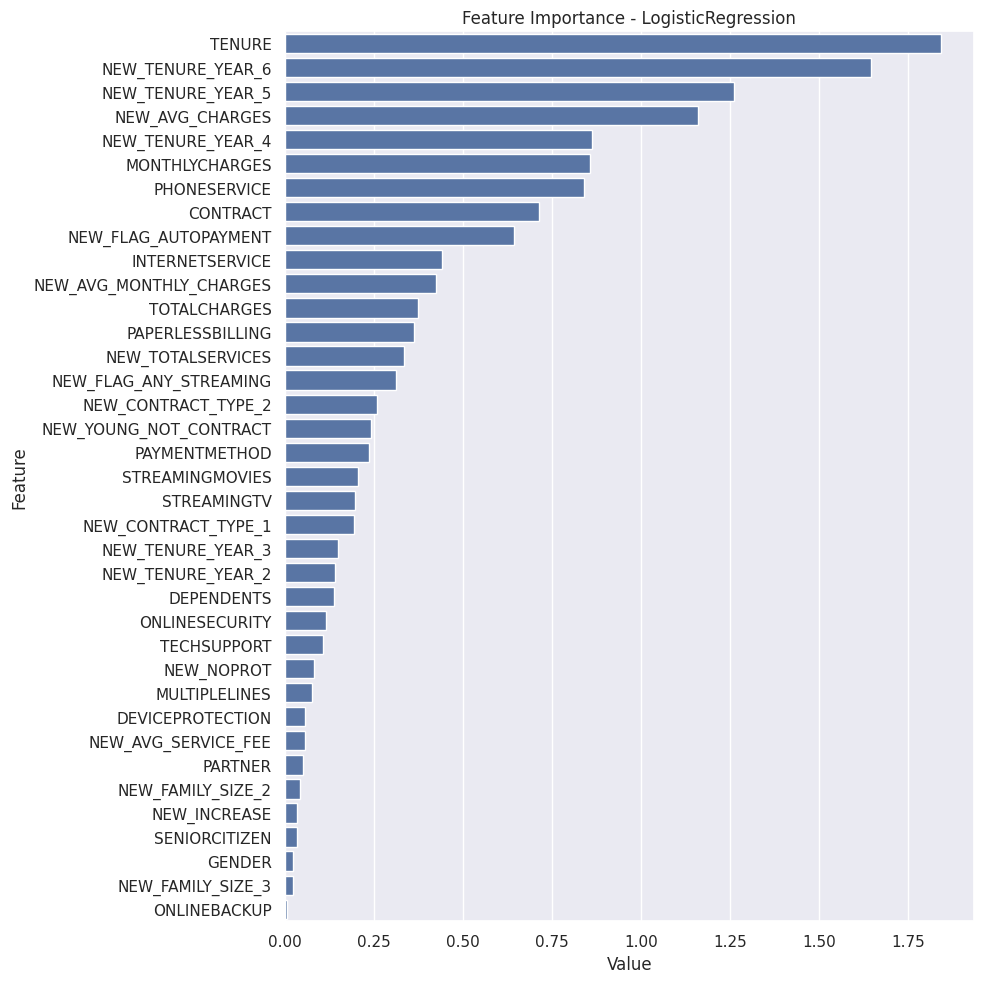

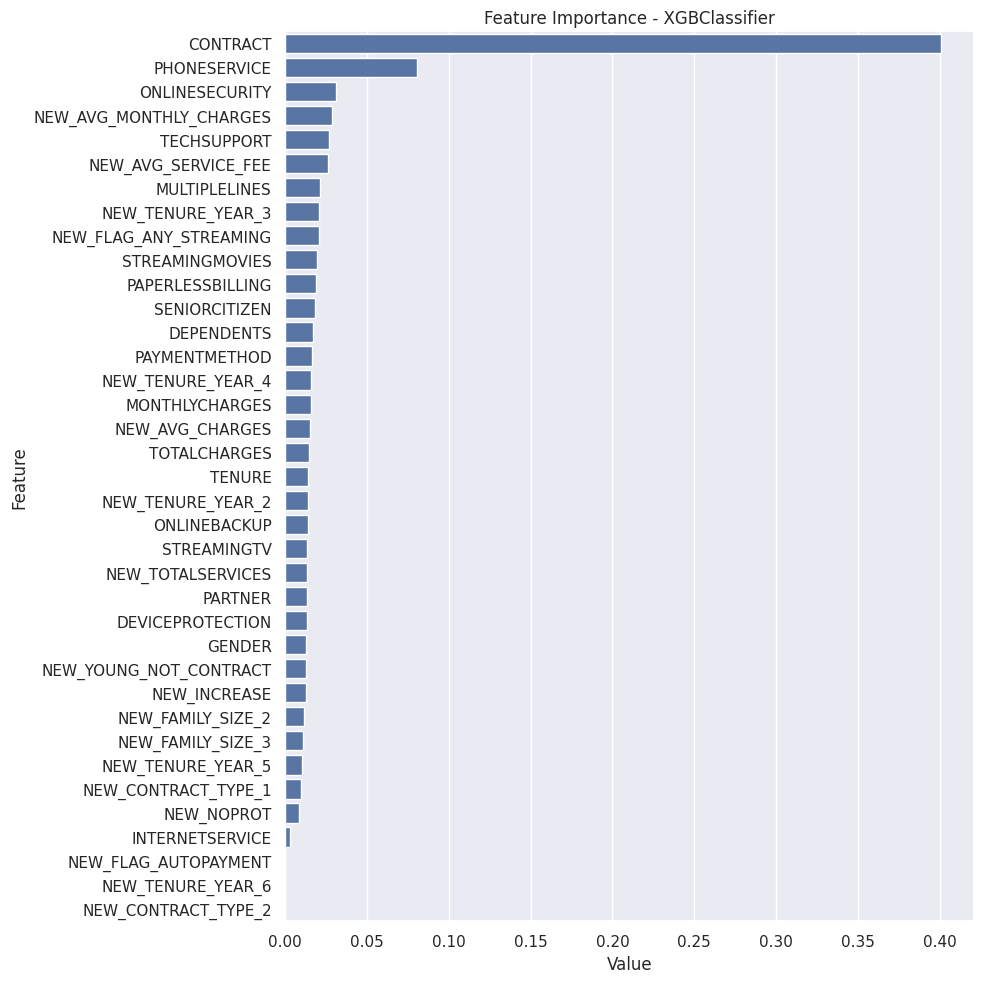

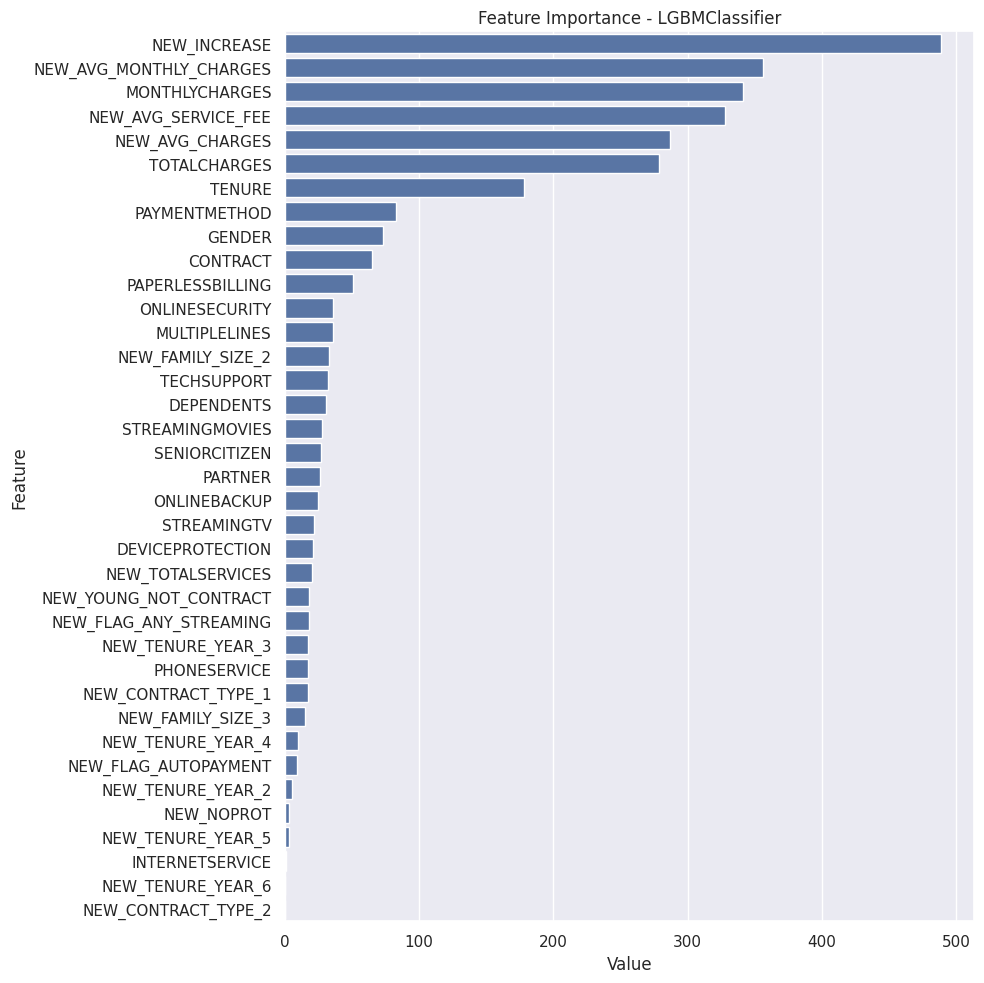

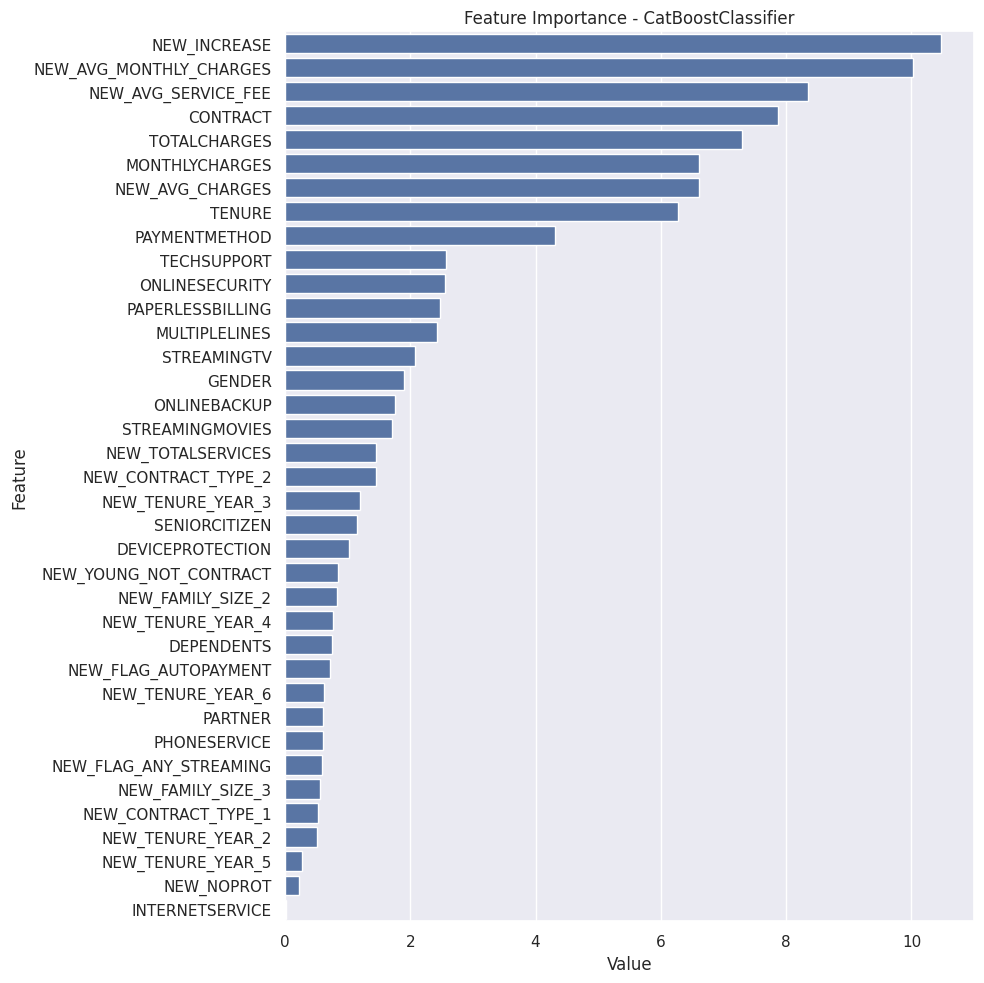

In [ ]:
def plot_importance(model, features, num=None, save=False):

    if num is None:
        num = len(features.columns)


    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):

        importances = model.coef_[0] if model.coef_.ndim == 2 else model.coef_
        importances = np.abs(importances)
    else:
        print(f"{model.__class__.__name__} modelinde özellik önem değerleri bulunamadı.")
        return

    feature_imp = pd.DataFrame({'Value': importances, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", ascending=False).iloc[:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')
    plt.show()

models = [RandomForestClassifier(),
          LogisticRegression(),
          XGBClassifier(),
          LGBMClassifier(),
          CatBoostClassifier(verbose=False, random_state=12345)
         ]

for model in models:
    model.fit(X, y)
    plot_importance(model, X)


Perbandingan Metrik untuk Model yang Berbeda Setelah Pengolahan Fitur

In [ ]:
# Dictionary containing the updated metric results
base_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}

last_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}

# Creating DataFrames from the metric dictionaries
base_results_df = pd.DataFrame(base_metrics)
last_results_df = pd.DataFrame(last_metrics)

# Calculating the improvement percentages for each metric
improvement_df = pd.DataFrame()
improvement_df["Model"] = base_results_df["Model"]
improvement_df["Accuracy"] = ((last_results_df["Accuracy"] - base_results_df["Accuracy"]) / base_results_df["Accuracy"]) * 100
improvement_df["AUC"] = ((last_results_df["AUC"] - base_results_df["AUC"]) / base_results_df["AUC"]) * 100
improvement_df["Recall"] = ((last_results_df["Recall"] - base_results_df["Recall"]) / base_results_df["Recall"]) * 100
improvement_df["Precision"] = ((last_results_df["Precision"] - base_results_df["Precision"]) / base_results_df["Precision"]) * 100
improvement_df["F1"] = ((last_results_df["F1"] - base_results_df["F1"]) / base_results_df["F1"]) * 100

# Sorting the DataFrame by accuracy improvement in descending order
improvement_df = improvement_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=improvement_df["Model"],
        y=improvement_df[metric],
        marker_color=color,
        name=metric,
        text=improvement_df[metric].apply(lambda x: f"{round(x, 2)}%"),
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Improvement Percentage",
    title="Metric Improvement Comparison After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)

In [ ]:
lr_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
knn_params = {"n_neighbors": [3, 5, 7]}
cart_params = {"max_depth": [3, 5, 7]}
rf_params = {"n_estimators": [100, 300, 500]}
xgb_params = {"learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]}
lgbm_params = {"learning_rate": [0.01, 0.1], "n_estimators": [100, 300, 500]}
catboost_params = {"iterations": [200, 500], "learning_rate": [0.01, 0.1], "depth": [3, 6]}

classifiers = [
    ("LR", LogisticRegression(), lr_params),
    ("KNN", KNeighborsClassifier(), knn_params),
    ("CART", DecisionTreeClassifier(), cart_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("XGB", XGBClassifier(), xgb_params),
    ("LGBM", LGBMClassifier(verbose=-1), lgbm_params),
    ("CatBoost", CatBoostClassifier(verbose=False), catboost_params)
]
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimization")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} #########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X,y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After) : {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models, final_model

best_models, final_model = hyperparameter_optimization(X, y)

Hyperparameter Optimization
########## LR #########
accuracy (Before): 0.8055
accuracy (After) : 0.8055
LR best params: {'C': 1}

########## KNN #########
accuracy (Before): 0.7622
accuracy (After) : 0.7646
KNN best params: {'n_neighbors': 7}

########## CART #########
accuracy (Before): 0.7304
accuracy (After) : 0.7866
CART best params: {'max_depth': 5}

########## RF #########
accuracy (Before): 0.7918
accuracy (After) : 0.7931
RF best params: {'n_estimators': 300}

########## XGB #########
accuracy (Before): 0.7789
accuracy (After) : 0.7997
XGB best params: {'learning_rate': 0.1, 'max_depth': 3}

########## LGBM #########
accuracy (Before): 0.7945
accuracy (After) : 0.7991
LGBM best params: {'learning_rate': 0.01, 'n_estimators': 500}

########## CatBoost #########
accuracy (Before): 0.7975
accuracy (After) : 0.8036
CatBoost best params: {'depth': 3, 'iterations': 500, 'learning_rate': 0.01}



In [ ]:
final_model

In [ ]:
print(final_model)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('CatBoost', best_models['CatBoost']),
        ('XGB', best_models['XGB']),
        ('LR', best_models['LR'])
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
y_proba_vote = voting_clf.predict_proba(X_test)[:, 1]


In [ ]:
print("\n📊 Voting Classifier Performance")
print(classification_report(y_test, y_pred_vote))

# AUC Voting
auc_vote = roc_auc_score(y_test, y_proba_vote)
print(f"AUC Voting: {auc_vote:.4f}")



📊 Voting Classifier Performance
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

AUC Voting: 0.8467


In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('CatBoost', best_models['CatBoost']),
        ('XGB', best_models['XGB']),
        ('LR', best_models['LR'])
    ],
    final_estimator=LogisticRegression(),
    passthrough=True,  # jika ingin fitur asli + prediksi base model dimasukkan ke final model
    cv=5
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]


In [ ]:
print("\n📊 Stacking Classifier Performance")
print(classification_report(y_test, y_pred_stack))

# AUC Stacking
auc_stack = roc_auc_score(y_test, y_proba_stack)
print(f"AUC Stacking: {auc_stack:.4f}")



📊 Stacking Classifier Performance
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

AUC Stacking: 0.8457


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ambil probabilitas prediksi (class=1)
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]

# Simpan hasil tiap threshold
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
results = []

for t in thresholds:
    y_pred_thresh = (y_proba_stack >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append((t, precision, recall, f1))

# Tampilkan hasil
print("Threshold | Precision | Recall | F1 Score")
for t, p, r, f in results:
    print(f"{t:9.2f} | {p:9.4f} | {r:6.4f} | {f:8.4f}")


Threshold | Precision | Recall | F1 Score
     0.30 |    0.5388 | 0.7620 |   0.6312
     0.35 |    0.5654 | 0.7166 |   0.6321
     0.40 |    0.5938 | 0.6684 |   0.6289
     0.45 |    0.6182 | 0.5802 |   0.5986
     0.50 |    0.6644 | 0.5294 |   0.5893
     0.55 |    0.6763 | 0.4358 |   0.5301
     0.60 |    0.7112 | 0.3556 |   0.4742


In [ ]:
# Final threshold
final_threshold = 0.35
y_final_stack = (y_proba_stack >= final_threshold).astype(int)

# Evaluasi ulang
print("\n📌 Evaluasi Stacking + Threshold 0.35")
print(classification_report(y_test, y_final_stack))
print(f"AUC: {roc_auc_score(y_test, y_proba_stack):.4f}")



📌 Evaluasi Stacking + Threshold 0.35
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1035
           1       0.57      0.72      0.63       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409

AUC: 0.8457


In [ ]:
import joblib

# Simpan model dan threshold
joblib.dump(stacking_clf, "stacking_model.pkl")
joblib.dump(0.35, "optimal_threshold.pkl")


['optimal_threshold.pkl']

In [ ]:
os.listdir('/content')

['.config',
 'optimal_threshold.pkl',
 'catboost_info',
 'stacking_model.pkl',
 'sample_data']

In [ ]:
from google.colab import files
files.download("/content/stacking_model.pkl")
files.download("/content/optimal_threshold.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

joblib.dump(X.columns.tolist(), "feature_names.pkl")


['feature_names.pkl']

In [ ]:
from google.colab import files
files.download("feature_names.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Insight dan Rekomendasi
- Pelanggan kontrak bulanan memiliki risiko churn tertinggi.
- Metode pembayaran "Electronic Check" paling banyak digunakan pelanggan yang churn.
- Pelanggan dengan `tenure < 12 bulan` lebih rentan churn.

###Rekomendasi:
- Penawaran diskon khusus untuk pelanggan kontrak bulanan.
- Mempromosikan metode pembayaran otomatis (auto-debit).
- Bangun loyalty program untuk pelanggan baru.
